In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



/tmp/ipykernel_1848250/3724148964.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data67_processing as dp


from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
batch_size = 8
num_workers = 4

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [4]:
device


device(type='cuda', index=0)

# Build dataset

In [5]:
# Dataset
directory  = '/net/projects/CLS/force_reference/data/TractionData_27_04_21_ZyxinPaxillin/'
# directory  = '/net/projects/CLS/force_reference/data/ZyxAct_16kPa_small/'

test_cells = 'cell_1'


in_channels  = [[7]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (6)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels,
                    'norm_output': {'rescale': 0.25, 'threshold': 0.4}
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'outside_inside', # Comment on what these do
                    'output_baseline_normalization': 'mean_dataset',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

{'crop_size': 512, 'output_channels': 6, 'norm_output': {'rescale': 0.25, 'threshold': 0.4}}


In [6]:
dataset

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [7]:
df = dataset.info.copy()

df.head(10)

,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in
0,cell_5,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
1,cell_5,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
2,cell_5,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
3,cell_5,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
4,cell_5,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
5,cell_5,Disp_Trac_CellMask_ForceMask_Actin_5.npy,5,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
6,cell_5,Disp_Trac_CellMask_ForceMask_Actin_6.npy,6,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
7,cell_5,Disp_Trac_CellMask_ForceMask_Actin_7.npy,7,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
8,cell_5,Disp_Trac_CellMask_ForceMask_Actin_8.npy,8,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
9,cell_5,Disp_Trac_CellMask_ForceMask_Actin_9.npy,9,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109


In [8]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_1']}
[415 364 448 476 403 450 423 431 387 404 436 380 416 439 413 405 378 420
 388 442 456 385 478 470 381 390 418 374 372 445 463 462 428 409 432 399
 392 453 482 433 402 406 479 398 386 468 467 430 422 427 446]


In [9]:
dataset.info

,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in
0,cell_5,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
1,cell_5,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
2,cell_5,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
3,cell_5,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
4,cell_5,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
...,...,...,...,...,...,...,...,...,...,...
479,cell_1,Disp_Trac_CellMask_ForceMask_Actin_116.npy,116,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,10.708059,127.223836,5.975600,36.764299
480,cell_1,Disp_Trac_CellMask_ForceMask_Actin_117.npy,117,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,10.708059,127.223836,5.975600,36.764299
481,cell_1,Disp_Trac_CellMask_ForceMask_Actin_118.npy,118,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,10.708059,127.223836,5.975600,36.764299
482,cell_1,Disp_Trac_CellMask_ForceMask_Actin_119.npy,119,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,10.708059,127.223836,5.975600,36.764299


In [10]:
cell = 'cell_1'
frame = 5

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

368


In [11]:
dataset.out_channels


6

In [12]:
sample = dataset[idx]

{'mask': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512]), 'output': torch.Size([1, 512, 512])}


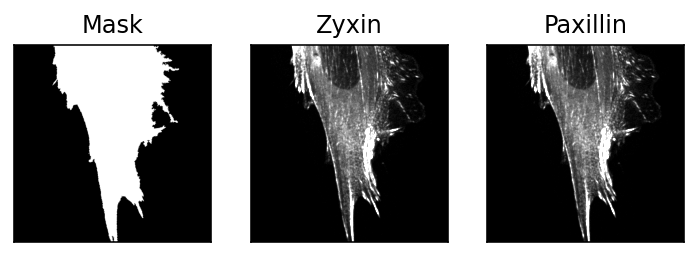

In [13]:
fig,ax=plt.subplots(1,3,figsize=(2*3, 4*2), dpi=144)


print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Zyxin')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)
ax[2].set_title('Paxillin')
ax[2].imshow(sample['output'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [14]:
sample

{'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'zyxin': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'actin': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'output': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0.

# Build U-Net model with ConvNext blocks

In [15]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.0005, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'r_mse',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }





models = {}
for protein in ['actin1','actin2']:
    modelname = 'model_p2z_150ep_loss'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 4}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein[:-1], 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': 'model_0'}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


In [16]:
models

{'actin1': UNet(
   (layers_encode): ModuleList(
     (0): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
         (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
       (4): DownsampleLayer(
         (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
     )
     (1): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
         (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  

In [17]:
protein[:-1]

'actin'

# Perform training

In [18]:
save_models = True
n_epochs = 150

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    for mkey in models.keys():
        models[mkey].reset_running_train_loss()
        models[mkey].reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        for mkey in models.keys():
            models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)
    
        for mkey in models.keys():
            models[mkey].validation_step(sample, epoch=e)

    for mkey in models.keys():
        models[mkey].scheduler.step()
        

    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))
    print('Loss: m0 '+str(models[0].get_running_val_loss()['mse_loss']) +'m1 '+str(models[1].get_running_val_loss()['mse_loss']))
    
    # SAVE
    if save_models:
        # Log in tensorboard
        # for mkey in models.keys():
        #     model[mkey].log_images(epoch=e)
        #     model[mkey].log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


Epoch 1:   1%|          | 32/4800.0 [01:20<1:25:56,  1.08s/it]

{'mse_loss': tensor(61.9630, device='cuda:0'), 'base_loss': tensor(61.9630, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(60.1931, device='cuda:0'), 'base_loss': tensor(60.1931, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 0:	 Time: 80.31 	(per epoch: 80.31)


Epoch 2:   1%|▏         | 64/4800.0 [01:48<51:25,  1.54it/s]  

{'mse_loss': tensor(23.6821, device='cuda:0'), 'base_loss': tensor(23.6821, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(28.1223, device='cuda:0'), 'base_loss': tensor(28.1223, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 1:	 Time: 108.68 	(per epoch: 54.34)


Epoch 3:   2%|▏         | 96/4800.0 [02:16<51:02,  1.54it/s]  

{'mse_loss': tensor(23.1732, device='cuda:0'), 'base_loss': tensor(23.1732, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(26.5104, device='cuda:0'), 'base_loss': tensor(26.5104, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 2:	 Time: 136.95 	(per epoch: 45.65)


Epoch 4:   3%|▎         | 128/4800.0 [02:45<50:31,  1.54it/s]  

{'mse_loss': tensor(28.5211, device='cuda:0'), 'base_loss': tensor(28.5211, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(21.1110, device='cuda:0'), 'base_loss': tensor(21.1110, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 3:	 Time: 165.53 	(per epoch: 41.38)


Epoch 5:   3%|▎         | 160/4800.0 [03:13<50:07,  1.54it/s]  

{'mse_loss': tensor(22.1515, device='cuda:0'), 'base_loss': tensor(22.1515, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(19.8331, device='cuda:0'), 'base_loss': tensor(19.8331, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 4:	 Time: 193.77 	(per epoch: 38.75)


Epoch 6:   4%|▍         | 192/4800.0 [03:42<49:46,  1.54it/s]  

{'mse_loss': tensor(20.1431, device='cuda:0'), 'base_loss': tensor(20.1431, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(29.5995, device='cuda:0'), 'base_loss': tensor(29.5995, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 5:	 Time: 222.10 	(per epoch: 37.02)


Epoch 7:   5%|▍         | 224/4800.0 [04:10<49:43,  1.53it/s]  

{'mse_loss': tensor(31.0341, device='cuda:0'), 'base_loss': tensor(31.0341, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(18.5002, device='cuda:0'), 'base_loss': tensor(18.5002, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 6:	 Time: 250.16 	(per epoch: 35.74)


Epoch 8:   5%|▌         | 256/4800.0 [04:38<49:04,  1.54it/s]  

{'mse_loss': tensor(19.4622, device='cuda:0'), 'base_loss': tensor(19.4622, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(31.8529, device='cuda:0'), 'base_loss': tensor(31.8529, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 7:	 Time: 278.39 	(per epoch: 34.80)


Epoch 9:   6%|▌         | 288/4800.0 [05:06<48:49,  1.54it/s]  

{'mse_loss': tensor(19.6049, device='cuda:0'), 'base_loss': tensor(19.6049, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(22.2533, device='cuda:0'), 'base_loss': tensor(22.2533, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 8:	 Time: 306.66 	(per epoch: 34.07)


Epoch 10:   7%|▋         | 320/4800.0 [05:34<48:20,  1.54it/s] 

{'mse_loss': tensor(17.5825, device='cuda:0'), 'base_loss': tensor(17.5825, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(16.5250, device='cuda:0'), 'base_loss': tensor(16.5250, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 9:	 Time: 334.89 	(per epoch: 33.49)


Epoch 11:   7%|▋         | 352/4800.0 [06:03<48:04,  1.54it/s]  

{'mse_loss': tensor(21.1860, device='cuda:0'), 'base_loss': tensor(21.1860, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(34.0068, device='cuda:0'), 'base_loss': tensor(34.0068, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 10:	 Time: 363.07 	(per epoch: 33.01)


Epoch 12:   8%|▊         | 384/4800.0 [06:31<47:41,  1.54it/s]  

{'mse_loss': tensor(22.5088, device='cuda:0'), 'base_loss': tensor(22.5088, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(39.8258, device='cuda:0'), 'base_loss': tensor(39.8258, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 11:	 Time: 391.37 	(per epoch: 32.61)


Epoch 13:   9%|▊         | 416/4800.0 [06:59<47:24,  1.54it/s]  

{'mse_loss': tensor(46.2742, device='cuda:0'), 'base_loss': tensor(46.2742, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(27.7542, device='cuda:0'), 'base_loss': tensor(27.7542, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 12:	 Time: 419.37 	(per epoch: 32.26)


Epoch 14:   9%|▉         | 448/4800.0 [07:27<47:05,  1.54it/s]  

{'mse_loss': tensor(46.7590, device='cuda:0'), 'base_loss': tensor(46.7590, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(25.9798, device='cuda:0'), 'base_loss': tensor(25.9798, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 13:	 Time: 447.75 	(per epoch: 31.98)


Epoch 15:  10%|█         | 480/4800.0 [07:56<46:48,  1.54it/s]  

{'mse_loss': tensor(18.0792, device='cuda:0'), 'base_loss': tensor(18.0792, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(19.6822, device='cuda:0'), 'base_loss': tensor(19.6822, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 14:	 Time: 476.42 	(per epoch: 31.76)


Epoch 16:  11%|█         | 512/4800.0 [08:24<46:33,  1.53it/s]  

{'mse_loss': tensor(18.5079, device='cuda:0'), 'base_loss': tensor(18.5079, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(36.4755, device='cuda:0'), 'base_loss': tensor(36.4755, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 15:	 Time: 504.63 	(per epoch: 31.54)


Epoch 17:  11%|█▏        | 544/4800.0 [08:52<45:52,  1.55it/s]  

{'mse_loss': tensor(21.6008, device='cuda:0'), 'base_loss': tensor(21.6008, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(16.7958, device='cuda:0'), 'base_loss': tensor(16.7958, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 16:	 Time: 532.75 	(per epoch: 31.34)


Epoch 18:  12%|█▏        | 576/4800.0 [09:20<45:43,  1.54it/s]  

{'mse_loss': tensor(43.2873, device='cuda:0'), 'base_loss': tensor(43.2873, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(16.5271, device='cuda:0'), 'base_loss': tensor(16.5271, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 17:	 Time: 560.88 	(per epoch: 31.16)


Epoch 19:  13%|█▎        | 608/4800.0 [09:49<45:11,  1.55it/s]  

{'mse_loss': tensor(27.4454, device='cuda:0'), 'base_loss': tensor(27.4454, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(45.0853, device='cuda:0'), 'base_loss': tensor(45.0853, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 18:	 Time: 589.01 	(per epoch: 31.00)


Epoch 20:  13%|█▎        | 640/4800.0 [10:17<45:16,  1.53it/s]  

{'mse_loss': tensor(19.2203, device='cuda:0'), 'base_loss': tensor(19.2203, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(35.1493, device='cuda:0'), 'base_loss': tensor(35.1493, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 19:	 Time: 617.21 	(per epoch: 30.86)


Epoch 21:  14%|█▍        | 672/4800.0 [10:45<44:40,  1.54it/s]  

{'mse_loss': tensor(43.1617, device='cuda:0'), 'base_loss': tensor(43.1617, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(16.5886, device='cuda:0'), 'base_loss': tensor(16.5886, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 20:	 Time: 645.49 	(per epoch: 30.74)


Epoch 22:  15%|█▍        | 704/4800.0 [11:14<44:26,  1.54it/s]  

{'mse_loss': tensor(18.7823, device='cuda:0'), 'base_loss': tensor(18.7823, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(26.2897, device='cuda:0'), 'base_loss': tensor(26.2897, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 21:	 Time: 674.03 	(per epoch: 30.64)


Epoch 23:  15%|█▌        | 736/4800.0 [11:41<43:45,  1.55it/s]  

{'mse_loss': tensor(78.9212, device='cuda:0'), 'base_loss': tensor(78.9212, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(27.4509, device='cuda:0'), 'base_loss': tensor(27.4509, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 22:	 Time: 701.90 	(per epoch: 30.52)


Epoch 24:  16%|█▌        | 768/4800.0 [12:10<43:28,  1.55it/s]  

{'mse_loss': tensor(29.7134, device='cuda:0'), 'base_loss': tensor(29.7134, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(15.8234, device='cuda:0'), 'base_loss': tensor(15.8234, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 23:	 Time: 730.15 	(per epoch: 30.42)


Epoch 25:  17%|█▋        | 800/4800.0 [12:38<43:06,  1.55it/s]  

{'mse_loss': tensor(48.7569, device='cuda:0'), 'base_loss': tensor(48.7569, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(15.9011, device='cuda:0'), 'base_loss': tensor(15.9011, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 24:	 Time: 758.67 	(per epoch: 30.35)


Epoch 26:  17%|█▋        | 832/4800.0 [13:06<42:46,  1.55it/s]  

{'mse_loss': tensor(83.6443, device='cuda:0'), 'base_loss': tensor(83.6443, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(56.3619, device='cuda:0'), 'base_loss': tensor(56.3619, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 25:	 Time: 786.73 	(per epoch: 30.26)


Epoch 27:  18%|█▊        | 864/4800.0 [13:35<42:25,  1.55it/s]  

{'mse_loss': tensor(141.2463, device='cuda:0'), 'base_loss': tensor(141.2463, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(21.3665, device='cuda:0'), 'base_loss': tensor(21.3665, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 26:	 Time: 815.14 	(per epoch: 30.19)


Epoch 28:  19%|█▊        | 896/4800.0 [14:03<42:01,  1.55it/s]  

{'mse_loss': tensor(52.6346, device='cuda:0'), 'base_loss': tensor(52.6346, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(50.9943, device='cuda:0'), 'base_loss': tensor(50.9943, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 27:	 Time: 843.07 	(per epoch: 30.11)


Epoch 29:  19%|█▉        | 928/4800.0 [14:31<41:48,  1.54it/s]  

{'mse_loss': tensor(16.0909, device='cuda:0'), 'base_loss': tensor(16.0909, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(44.0492, device='cuda:0'), 'base_loss': tensor(44.0492, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 28:	 Time: 871.20 	(per epoch: 30.04)


Epoch 30:  20%|██        | 960/4800.0 [14:59<41:30,  1.54it/s]  

{'mse_loss': tensor(57.1401, device='cuda:0'), 'base_loss': tensor(57.1401, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(46.5202, device='cuda:0'), 'base_loss': tensor(46.5202, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 29:	 Time: 899.53 	(per epoch: 29.98)


Epoch 31:  21%|██        | 992/4800.0 [15:27<40:58,  1.55it/s]  

{'mse_loss': tensor(63.7195, device='cuda:0'), 'base_loss': tensor(63.7195, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
{'mse_loss': tensor(23.9404, device='cuda:0'), 'base_loss': tensor(23.9404, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0}
Epoch 30:	 Time: 927.58 	(per epoch: 29.92)


Epoch 32:  21%|██▏       | 1024/4800.0 [15:55<40:40,  1.55it/s] 

{'mse_loss': tensor(36.6688, device='cuda:0'), 'base_loss': tensor(36.6688, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.022580645161290325}
{'mse_loss': tensor(30.8434, device='cuda:0'), 'base_loss': tensor(30.8434, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.022580645161290325}
Epoch 31:	 Time: 955.60 	(per epoch: 29.86)


Epoch 33:  22%|██▏       | 1056/4800.0 [16:24<40:22,  1.55it/s]  

{'mse_loss': tensor(79.6016, device='cuda:0'), 'base_loss': tensor(79.6016, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.04516129032258065}
{'mse_loss': tensor(31.3023, device='cuda:0'), 'base_loss': tensor(31.3023, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.04516129032258065}
Epoch 32:	 Time: 983.93 	(per epoch: 29.82)


Epoch 34:  23%|██▎       | 1088/4800.0 [16:52<40:09,  1.54it/s]  

{'mse_loss': tensor(75.4451, device='cuda:0'), 'base_loss': tensor(75.4451, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.06774193548387096}
{'mse_loss': tensor(34.6665, device='cuda:0'), 'base_loss': tensor(34.6665, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.06774193548387096}
Epoch 33:	 Time: 1012.24 	(per epoch: 29.77)


Epoch 35:  23%|██▎       | 1120/4800.0 [17:20<39:50,  1.54it/s]  

{'mse_loss': tensor(33.8312, device='cuda:0'), 'base_loss': tensor(33.8312, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0903225806451613}
{'mse_loss': tensor(14.1699, device='cuda:0'), 'base_loss': tensor(14.1699, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.0903225806451613}
Epoch 34:	 Time: 1040.59 	(per epoch: 29.73)


Epoch 36:  24%|██▍       | 1152/4800.0 [17:49<39:42,  1.53it/s]  

{'mse_loss': tensor(52.4077, device='cuda:0'), 'base_loss': tensor(52.4077, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.11290322580645161}
{'mse_loss': tensor(34.2535, device='cuda:0'), 'base_loss': tensor(34.2535, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.11290322580645161}
Epoch 35:	 Time: 1069.12 	(per epoch: 29.70)


Epoch 37:  25%|██▍       | 1184/4800.0 [18:17<39:09,  1.54it/s]  

{'mse_loss': tensor(19.2796, device='cuda:0'), 'base_loss': tensor(19.2796, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.13548387096774192}
{'mse_loss': tensor(31.3572, device='cuda:0'), 'base_loss': tensor(31.3572, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.13548387096774192}
Epoch 36:	 Time: 1097.38 	(per epoch: 29.66)


Epoch 38:  25%|██▌       | 1216/4800.0 [18:45<38:46,  1.54it/s]  

{'mse_loss': tensor(49.2119, device='cuda:0'), 'base_loss': tensor(49.2119, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.15806451612903225}
{'mse_loss': tensor(52.2969, device='cuda:0'), 'base_loss': tensor(52.2969, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.15806451612903225}
Epoch 37:	 Time: 1125.69 	(per epoch: 29.62)


Epoch 39:  26%|██▌       | 1248/4800.0 [19:13<38:21,  1.54it/s]  

{'mse_loss': tensor(18.9918, device='cuda:0'), 'base_loss': tensor(18.9918, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.1806451612903226}
{'mse_loss': tensor(26.0813, device='cuda:0'), 'base_loss': tensor(26.0813, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.1806451612903226}
Epoch 38:	 Time: 1153.87 	(per epoch: 29.59)


Epoch 40:  27%|██▋       | 1280/4800.0 [19:42<38:06,  1.54it/s]  

{'mse_loss': tensor(68.4309, device='cuda:0'), 'base_loss': tensor(68.4309, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.2032258064516129}
{'mse_loss': tensor(17.5487, device='cuda:0'), 'base_loss': tensor(17.5487, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.2032258064516129}
Epoch 39:	 Time: 1182.01 	(per epoch: 29.55)


Epoch 41:  27%|██▋       | 1312/4800.0 [20:10<37:41,  1.54it/s]  

{'mse_loss': tensor(19.4931, device='cuda:0'), 'base_loss': tensor(19.4931, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.22580645161290322}
{'mse_loss': tensor(39.4670, device='cuda:0'), 'base_loss': tensor(39.4670, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.22580645161290322}
Epoch 40:	 Time: 1210.19 	(per epoch: 29.52)


Epoch 42:  28%|██▊       | 1344/4800.0 [20:38<37:18,  1.54it/s]  

{'mse_loss': tensor(45.2176, device='cuda:0'), 'base_loss': tensor(45.2176, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.24838709677419357}
{'mse_loss': tensor(41.4046, device='cuda:0'), 'base_loss': tensor(41.4046, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.24838709677419357}
Epoch 41:	 Time: 1238.76 	(per epoch: 29.49)


Epoch 43:  29%|██▊       | 1376/4800.0 [21:06<36:53,  1.55it/s]  

{'mse_loss': tensor(49.3642, device='cuda:0'), 'base_loss': tensor(49.3642, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.27096774193548384}
{'mse_loss': tensor(19.8925, device='cuda:0'), 'base_loss': tensor(19.8925, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.27096774193548384}
Epoch 42:	 Time: 1266.91 	(per epoch: 29.46)


Epoch 44:  29%|██▉       | 1408/4800.0 [21:35<36:36,  1.54it/s]  

{'mse_loss': tensor(28.1646, device='cuda:0'), 'base_loss': tensor(28.1646, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.2935483870967742}
{'mse_loss': tensor(35.2751, device='cuda:0'), 'base_loss': tensor(35.2751, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.2935483870967742}
Epoch 43:	 Time: 1295.03 	(per epoch: 29.43)


Epoch 45:  30%|███       | 1440/4800.0 [22:03<36:26,  1.54it/s]  

{'mse_loss': tensor(23.7742, device='cuda:0'), 'base_loss': tensor(23.7742, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3161290322580645}
{'mse_loss': tensor(41.7726, device='cuda:0'), 'base_loss': tensor(41.7726, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3161290322580645}
Epoch 44:	 Time: 1323.21 	(per epoch: 29.40)


Epoch 46:  31%|███       | 1472/4800.0 [22:32<36:10,  1.53it/s]  

{'mse_loss': tensor(29.3342, device='cuda:0'), 'base_loss': tensor(29.3342, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.33870967741935487}
{'mse_loss': tensor(35.7144, device='cuda:0'), 'base_loss': tensor(35.7144, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.33870967741935487}
Epoch 45:	 Time: 1352.11 	(per epoch: 29.39)


Epoch 47:  31%|███▏      | 1504/4800.0 [23:00<35:43,  1.54it/s]  

{'mse_loss': tensor(42.5645, device='cuda:0'), 'base_loss': tensor(42.5645, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3612903225806452}
{'mse_loss': tensor(21.9390, device='cuda:0'), 'base_loss': tensor(21.9390, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3612903225806452}
Epoch 46:	 Time: 1380.30 	(per epoch: 29.37)


Epoch 48:  32%|███▏      | 1536/4800.0 [23:28<35:19,  1.54it/s]  

{'mse_loss': tensor(33.9253, device='cuda:0'), 'base_loss': tensor(33.9253, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3838709677419354}
{'mse_loss': tensor(18.4595, device='cuda:0'), 'base_loss': tensor(18.4595, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.3838709677419354}
Epoch 47:	 Time: 1408.48 	(per epoch: 29.34)


Epoch 49:  33%|███▎      | 1568/4800.0 [23:56<34:49,  1.55it/s]  

{'mse_loss': tensor(21.1381, device='cuda:0'), 'base_loss': tensor(21.1381, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4064516129032258}
{'mse_loss': tensor(19.9767, device='cuda:0'), 'base_loss': tensor(19.9767, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4064516129032258}
Epoch 48:	 Time: 1436.84 	(per epoch: 29.32)


Epoch 50:  33%|███▎      | 1600/4800.0 [24:25<34:38,  1.54it/s]  

{'mse_loss': tensor(29.7332, device='cuda:0'), 'base_loss': tensor(29.7332, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4290322580645161}
{'mse_loss': tensor(31.3454, device='cuda:0'), 'base_loss': tensor(31.3454, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4290322580645161}
Epoch 49:	 Time: 1465.36 	(per epoch: 29.31)


Epoch 51:  34%|███▍      | 1632/4800.0 [24:53<34:21,  1.54it/s]  

{'mse_loss': tensor(43.4831, device='cuda:0'), 'base_loss': tensor(43.4831, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.45161290322580644}
{'mse_loss': tensor(32.6527, device='cuda:0'), 'base_loss': tensor(32.6527, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.45161290322580644}
Epoch 50:	 Time: 1493.74 	(per epoch: 29.29)


Epoch 52:  35%|███▍      | 1664/4800.0 [25:21<33:52,  1.54it/s]  

{'mse_loss': tensor(38.5843, device='cuda:0'), 'base_loss': tensor(38.5843, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4741935483870968}
{'mse_loss': tensor(27.1640, device='cuda:0'), 'base_loss': tensor(27.1640, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.4741935483870968}
Epoch 51:	 Time: 1521.99 	(per epoch: 29.27)


Epoch 53:  35%|███▌      | 1696/4800.0 [25:50<33:34,  1.54it/s]  

{'mse_loss': tensor(44.1985, device='cuda:0'), 'base_loss': tensor(44.1985, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.49677419354838714}
{'mse_loss': tensor(22.3351, device='cuda:0'), 'base_loss': tensor(22.3351, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.49677419354838714}
Epoch 52:	 Time: 1550.57 	(per epoch: 29.26)


Epoch 54:  36%|███▌      | 1728/4800.0 [26:18<33:07,  1.55it/s]  

{'mse_loss': tensor(41.3231, device='cuda:0'), 'base_loss': tensor(41.3231, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5193548387096775}
{'mse_loss': tensor(31.3067, device='cuda:0'), 'base_loss': tensor(31.3067, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5193548387096775}
Epoch 53:	 Time: 1578.85 	(per epoch: 29.24)


Epoch 55:  37%|███▋      | 1760/4800.0 [26:46<32:52,  1.54it/s]  

{'mse_loss': tensor(23.7727, device='cuda:0'), 'base_loss': tensor(23.7727, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5419354838709677}
{'mse_loss': tensor(28.0656, device='cuda:0'), 'base_loss': tensor(28.0656, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5419354838709677}
Epoch 54:	 Time: 1606.92 	(per epoch: 29.22)


Epoch 56:  37%|███▋      | 1792/4800.0 [27:15<32:27,  1.54it/s]  

{'mse_loss': tensor(14.3688, device='cuda:0'), 'base_loss': tensor(14.3688, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.564516129032258}
{'mse_loss': tensor(17.6447, device='cuda:0'), 'base_loss': tensor(17.6447, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.564516129032258}
Epoch 55:	 Time: 1635.04 	(per epoch: 29.20)


Epoch 57:  38%|███▊      | 1824/4800.0 [27:43<32:11,  1.54it/s]  

{'mse_loss': tensor(41.2832, device='cuda:0'), 'base_loss': tensor(41.2832, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5870967741935484}
{'mse_loss': tensor(17.0104, device='cuda:0'), 'base_loss': tensor(17.0104, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.5870967741935484}
Epoch 56:	 Time: 1663.18 	(per epoch: 29.18)


Epoch 58:  39%|███▊      | 1856/4800.0 [28:11<31:49,  1.54it/s]  

{'mse_loss': tensor(34.2051, device='cuda:0'), 'base_loss': tensor(34.2051, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6096774193548387}
{'mse_loss': tensor(34.5301, device='cuda:0'), 'base_loss': tensor(34.5301, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6096774193548387}
Epoch 57:	 Time: 1691.26 	(per epoch: 29.16)


Epoch 59:  39%|███▉      | 1888/4800.0 [28:39<31:26,  1.54it/s]  

{'mse_loss': tensor(43.4258, device='cuda:0'), 'base_loss': tensor(43.4258, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.632258064516129}
{'mse_loss': tensor(20.6877, device='cuda:0'), 'base_loss': tensor(20.6877, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.632258064516129}
Epoch 58:	 Time: 1719.20 	(per epoch: 29.14)


Epoch 60:  40%|████      | 1920/4800.0 [29:07<31:00,  1.55it/s]  

{'mse_loss': tensor(17.2786, device='cuda:0'), 'base_loss': tensor(17.2786, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6548387096774193}
{'mse_loss': tensor(34.3721, device='cuda:0'), 'base_loss': tensor(34.3721, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6548387096774193}
Epoch 59:	 Time: 1747.35 	(per epoch: 29.12)


Epoch 61:  41%|████      | 1952/4800.0 [29:35<30:50,  1.54it/s]  

{'mse_loss': tensor(39.3778, device='cuda:0'), 'base_loss': tensor(39.3778, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6774193548387097}
{'mse_loss': tensor(18.9270, device='cuda:0'), 'base_loss': tensor(18.9270, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.6774193548387097}
Epoch 60:	 Time: 1775.28 	(per epoch: 29.10)


Epoch 62:  41%|████▏     | 1984/4800.0 [30:03<30:26,  1.54it/s]  

{'mse_loss': tensor(46.2263, device='cuda:0'), 'base_loss': tensor(46.2263, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7}
{'mse_loss': tensor(32.4582, device='cuda:0'), 'base_loss': tensor(32.4582, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7}
Epoch 61:	 Time: 1803.47 	(per epoch: 29.09)


Epoch 63:  42%|████▏     | 2016/4800.0 [30:31<30:10,  1.54it/s]  

{'mse_loss': tensor(21.3869, device='cuda:0'), 'base_loss': tensor(21.3869, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7225806451612904}
{'mse_loss': tensor(32.9180, device='cuda:0'), 'base_loss': tensor(32.9180, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7225806451612904}
Epoch 62:	 Time: 1831.47 	(per epoch: 29.07)


Epoch 64:  43%|████▎     | 2048/4800.0 [30:59<29:37,  1.55it/s]  

{'mse_loss': tensor(39.9408, device='cuda:0'), 'base_loss': tensor(39.9408, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7451612903225806}
{'mse_loss': tensor(23.9045, device='cuda:0'), 'base_loss': tensor(23.9045, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7451612903225806}
Epoch 63:	 Time: 1859.53 	(per epoch: 29.06)


Epoch 65:  43%|████▎     | 2080/4800.0 [31:27<29:17,  1.55it/s]  

{'mse_loss': tensor(35.8846, device='cuda:0'), 'base_loss': tensor(35.8846, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7677419354838708}
{'mse_loss': tensor(23.8977, device='cuda:0'), 'base_loss': tensor(23.8977, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7677419354838708}
Epoch 64:	 Time: 1887.92 	(per epoch: 29.04)


Epoch 66:  44%|████▍     | 2112/4800.0 [31:55<29:03,  1.54it/s]  

{'mse_loss': tensor(30.2627, device='cuda:0'), 'base_loss': tensor(30.2627, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7903225806451613}
{'mse_loss': tensor(19.2731, device='cuda:0'), 'base_loss': tensor(19.2731, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.7903225806451613}
Epoch 65:	 Time: 1915.94 	(per epoch: 29.03)


Epoch 67:  45%|████▍     | 2144/4800.0 [32:24<29:19,  1.51it/s]  

{'mse_loss': tensor(50.1828, device='cuda:0'), 'base_loss': tensor(50.1828, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8129032258064516}
{'mse_loss': tensor(15.2172, device='cuda:0'), 'base_loss': tensor(15.2172, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8129032258064516}
Epoch 66:	 Time: 1944.50 	(per epoch: 29.02)


Epoch 68:  45%|████▌     | 2176/4800.0 [32:52<28:21,  1.54it/s]  

{'mse_loss': tensor(15.9645, device='cuda:0'), 'base_loss': tensor(15.9645, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.835483870967742}
{'mse_loss': tensor(17.6767, device='cuda:0'), 'base_loss': tensor(17.6767, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.835483870967742}
Epoch 67:	 Time: 1972.44 	(per epoch: 29.01)


Epoch 69:  46%|████▌     | 2208/4800.0 [33:20<27:54,  1.55it/s]  

{'mse_loss': tensor(44.8973, device='cuda:0'), 'base_loss': tensor(44.8973, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8580645161290322}
{'mse_loss': tensor(20.4481, device='cuda:0'), 'base_loss': tensor(20.4481, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8580645161290322}
Epoch 68:	 Time: 2000.40 	(per epoch: 28.99)


Epoch 70:  47%|████▋     | 2240/4800.0 [33:48<27:33,  1.55it/s]  

{'mse_loss': tensor(25.2101, device='cuda:0'), 'base_loss': tensor(25.2101, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8806451612903223}
{'mse_loss': tensor(19.7306, device='cuda:0'), 'base_loss': tensor(19.7306, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.8806451612903223}
Epoch 69:	 Time: 2028.88 	(per epoch: 28.98)


Epoch 71:  47%|████▋     | 2272/4800.0 [34:16<27:21,  1.54it/s]  

{'mse_loss': tensor(44.2188, device='cuda:0'), 'base_loss': tensor(44.2188, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9032258064516129}
{'mse_loss': tensor(33.3855, device='cuda:0'), 'base_loss': tensor(33.3855, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9032258064516129}
Epoch 70:	 Time: 2056.87 	(per epoch: 28.97)


Epoch 72:  48%|████▊     | 2304/4800.0 [34:44<26:55,  1.54it/s]  

{'mse_loss': tensor(41.4703, device='cuda:0'), 'base_loss': tensor(41.4703, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9258064516129034}
{'mse_loss': tensor(17.8892, device='cuda:0'), 'base_loss': tensor(17.8892, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9258064516129034}
Epoch 71:	 Time: 2084.87 	(per epoch: 28.96)


Epoch 73:  49%|████▊     | 2336/4800.0 [35:12<26:36,  1.54it/s]  

{'mse_loss': tensor(38.9370, device='cuda:0'), 'base_loss': tensor(38.9370, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9483870967741936}
{'mse_loss': tensor(36.5762, device='cuda:0'), 'base_loss': tensor(36.5762, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9483870967741936}
Epoch 72:	 Time: 2112.87 	(per epoch: 28.94)


Epoch 74:  49%|████▉     | 2368/4800.0 [35:41<26:18,  1.54it/s]  

{'mse_loss': tensor(26.7757, device='cuda:0'), 'base_loss': tensor(26.7757, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9709677419354837}
{'mse_loss': tensor(20.1047, device='cuda:0'), 'base_loss': tensor(20.1047, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9709677419354837}
Epoch 73:	 Time: 2141.27 	(per epoch: 28.94)


Epoch 75:  50%|█████     | 2400/4800.0 [36:09<25:51,  1.55it/s]  

{'mse_loss': tensor(27.4301, device='cuda:0'), 'base_loss': tensor(27.4301, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9935483870967743}
{'mse_loss': tensor(28.8874, device='cuda:0'), 'base_loss': tensor(28.8874, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 0.9935483870967743}
Epoch 74:	 Time: 2169.62 	(per epoch: 28.93)


Epoch 76:  51%|█████     | 2432/4800.0 [36:38<25:45,  1.53it/s]  

{'mse_loss': tensor(60.8980, device='cuda:0'), 'base_loss': tensor(60.8980, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0161290322580645}
{'mse_loss': tensor(17.4754, device='cuda:0'), 'base_loss': tensor(17.4754, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0161290322580645}
Epoch 75:	 Time: 2198.00 	(per epoch: 28.92)


Epoch 77:  51%|█████▏    | 2464/4800.0 [37:06<25:12,  1.54it/s]  

{'mse_loss': tensor(29.2049, device='cuda:0'), 'base_loss': tensor(29.2049, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.038709677419355}
{'mse_loss': tensor(40.6596, device='cuda:0'), 'base_loss': tensor(40.6596, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.038709677419355}
Epoch 76:	 Time: 2225.97 	(per epoch: 28.91)


Epoch 78:  52%|█████▏    | 2496/4800.0 [37:34<24:58,  1.54it/s]  

{'mse_loss': tensor(30.9298, device='cuda:0'), 'base_loss': tensor(30.9298, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0612903225806452}
{'mse_loss': tensor(24.6100, device='cuda:0'), 'base_loss': tensor(24.6100, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0612903225806452}
Epoch 77:	 Time: 2254.25 	(per epoch: 28.90)


Epoch 79:  53%|█████▎    | 2528/4800.0 [38:02<24:36,  1.54it/s]  

{'mse_loss': tensor(37.5953, device='cuda:0'), 'base_loss': tensor(37.5953, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0838709677419354}
{'mse_loss': tensor(30.2744, device='cuda:0'), 'base_loss': tensor(30.2744, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.0838709677419354}
Epoch 78:	 Time: 2282.33 	(per epoch: 28.89)


Epoch 80:  53%|█████▎    | 2560/4800.0 [38:30<24:10,  1.54it/s]  

{'mse_loss': tensor(34.1790, device='cuda:0'), 'base_loss': tensor(34.1790, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1064516129032258}
{'mse_loss': tensor(29.8350, device='cuda:0'), 'base_loss': tensor(29.8350, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1064516129032258}
Epoch 79:	 Time: 2310.71 	(per epoch: 28.88)


Epoch 81:  54%|█████▍    | 2592/4800.0 [38:59<23:49,  1.54it/s]  

{'mse_loss': tensor(45.2067, device='cuda:0'), 'base_loss': tensor(45.2067, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.129032258064516}
{'mse_loss': tensor(22.7198, device='cuda:0'), 'base_loss': tensor(22.7198, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.129032258064516}
Epoch 80:	 Time: 2339.13 	(per epoch: 28.88)


Epoch 82:  55%|█████▍    | 2624/4800.0 [39:27<24:09,  1.50it/s]  

{'mse_loss': tensor(26.0934, device='cuda:0'), 'base_loss': tensor(26.0934, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1516129032258065}
{'mse_loss': tensor(27.4391, device='cuda:0'), 'base_loss': tensor(27.4391, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1516129032258065}
Epoch 81:	 Time: 2367.38 	(per epoch: 28.87)


Epoch 83:  55%|█████▌    | 2656/4800.0 [39:55<23:09,  1.54it/s]  

{'mse_loss': tensor(41.7678, device='cuda:0'), 'base_loss': tensor(41.7678, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1741935483870969}
{'mse_loss': tensor(31.0224, device='cuda:0'), 'base_loss': tensor(31.0224, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1741935483870969}
Epoch 82:	 Time: 2395.51 	(per epoch: 28.86)


Epoch 84:  56%|█████▌    | 2688/4800.0 [40:23<22:58,  1.53it/s]  

{'mse_loss': tensor(47.7094, device='cuda:0'), 'base_loss': tensor(47.7094, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1967741935483869}
{'mse_loss': tensor(37.4949, device='cuda:0'), 'base_loss': tensor(37.4949, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.1967741935483869}
Epoch 83:	 Time: 2423.95 	(per epoch: 28.86)


Epoch 85:  57%|█████▋    | 2720/4800.0 [40:52<22:37,  1.53it/s]  

{'mse_loss': tensor(17.7713, device='cuda:0'), 'base_loss': tensor(17.7713, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.2193548387096773}
{'mse_loss': tensor(22.5169, device='cuda:0'), 'base_loss': tensor(22.5169, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.2193548387096773}
Epoch 84:	 Time: 2452.33 	(per epoch: 28.85)


Epoch 86:  57%|█████▋    | 2752/4800.0 [41:20<22:08,  1.54it/s]  

{'mse_loss': tensor(35.9070, device='cuda:0'), 'base_loss': tensor(35.9070, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.241935483870968}
{'mse_loss': tensor(16.9003, device='cuda:0'), 'base_loss': tensor(16.9003, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.241935483870968}
Epoch 85:	 Time: 2480.81 	(per epoch: 28.85)


Epoch 87:  58%|█████▊    | 2784/4800.0 [41:48<21:47,  1.54it/s]  

{'mse_loss': tensor(38.7336, device='cuda:0'), 'base_loss': tensor(38.7336, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.264516129032258}
{'mse_loss': tensor(30.0342, device='cuda:0'), 'base_loss': tensor(30.0342, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.264516129032258}
Epoch 86:	 Time: 2508.91 	(per epoch: 28.84)


Epoch 88:  59%|█████▊    | 2816/4800.0 [42:17<21:19,  1.55it/s]  

{'mse_loss': tensor(44.8876, device='cuda:0'), 'base_loss': tensor(44.8876, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.2870967741935484}
{'mse_loss': tensor(39.5364, device='cuda:0'), 'base_loss': tensor(39.5364, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.2870967741935484}
Epoch 87:	 Time: 2537.48 	(per epoch: 28.84)


Epoch 89:  59%|█████▉    | 2848/4800.0 [42:45<21:02,  1.55it/s]  

{'mse_loss': tensor(34.3999, device='cuda:0'), 'base_loss': tensor(34.3999, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3096774193548386}
{'mse_loss': tensor(28.7550, device='cuda:0'), 'base_loss': tensor(28.7550, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3096774193548386}
Epoch 88:	 Time: 2565.61 	(per epoch: 28.83)


Epoch 90:  60%|██████    | 2880/4800.0 [43:13<20:42,  1.55it/s]  

{'mse_loss': tensor(21.2686, device='cuda:0'), 'base_loss': tensor(21.2686, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3322580645161288}
{'mse_loss': tensor(33.0265, device='cuda:0'), 'base_loss': tensor(33.0265, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3322580645161288}
Epoch 89:	 Time: 2593.61 	(per epoch: 28.82)


Epoch 91:  61%|██████    | 2912/4800.0 [43:41<20:22,  1.54it/s]  

{'mse_loss': tensor(16.7152, device='cuda:0'), 'base_loss': tensor(16.7152, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3548387096774195}
{'mse_loss': tensor(24.5792, device='cuda:0'), 'base_loss': tensor(24.5792, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3548387096774195}
Epoch 90:	 Time: 2621.67 	(per epoch: 28.81)


Epoch 92:  61%|██████▏   | 2944/4800.0 [44:09<19:57,  1.55it/s]  

{'mse_loss': tensor(43.2795, device='cuda:0'), 'base_loss': tensor(43.2795, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3774193548387097}
{'mse_loss': tensor(18.7447, device='cuda:0'), 'base_loss': tensor(18.7447, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.3774193548387097}
Epoch 91:	 Time: 2649.92 	(per epoch: 28.80)


Epoch 93:  62%|██████▏   | 2976/4800.0 [44:38<19:38,  1.55it/s]  

{'mse_loss': tensor(50.0825, device='cuda:0'), 'base_loss': tensor(50.0825, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4}
{'mse_loss': tensor(22.1680, device='cuda:0'), 'base_loss': tensor(22.1680, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4}
Epoch 92:	 Time: 2678.13 	(per epoch: 28.80)


Epoch 94:  63%|██████▎   | 3008/4800.0 [45:06<19:27,  1.53it/s]  

{'mse_loss': tensor(33.9840, device='cuda:0'), 'base_loss': tensor(33.9840, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4225806451612901}
{'mse_loss': tensor(16.6163, device='cuda:0'), 'base_loss': tensor(16.6163, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4225806451612901}
Epoch 93:	 Time: 2706.44 	(per epoch: 28.79)


Epoch 95:  63%|██████▎   | 3040/4800.0 [45:34<18:58,  1.55it/s]  

{'mse_loss': tensor(49.7589, device='cuda:0'), 'base_loss': tensor(49.7589, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4451612903225808}
{'mse_loss': tensor(15.8355, device='cuda:0'), 'base_loss': tensor(15.8355, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4451612903225808}
Epoch 94:	 Time: 2734.40 	(per epoch: 28.78)


Epoch 96:  64%|██████▍   | 3072/4800.0 [46:02<18:40,  1.54it/s]  

{'mse_loss': tensor(35.8282, device='cuda:0'), 'base_loss': tensor(35.8282, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.467741935483871}
{'mse_loss': tensor(36.4473, device='cuda:0'), 'base_loss': tensor(36.4473, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.467741935483871}
Epoch 95:	 Time: 2762.44 	(per epoch: 28.78)


Epoch 97:  65%|██████▍   | 3104/4800.0 [46:30<18:18,  1.54it/s]  

{'mse_loss': tensor(36.0494, device='cuda:0'), 'base_loss': tensor(36.0494, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4903225806451612}
{'mse_loss': tensor(20.6188, device='cuda:0'), 'base_loss': tensor(20.6188, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.4903225806451612}
Epoch 96:	 Time: 2790.50 	(per epoch: 28.77)


Epoch 98:  65%|██████▌   | 3136/4800.0 [46:59<18:10,  1.53it/s]  

{'mse_loss': tensor(39.8993, device='cuda:0'), 'base_loss': tensor(39.8993, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5129032258064514}
{'mse_loss': tensor(20.1546, device='cuda:0'), 'base_loss': tensor(20.1546, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5129032258064514}
Epoch 97:	 Time: 2819.06 	(per epoch: 28.77)


Epoch 99:  66%|██████▌   | 3168/4800.0 [47:27<17:35,  1.55it/s]  

{'mse_loss': tensor(25.6321, device='cuda:0'), 'base_loss': tensor(25.6321, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5354838709677416}
{'mse_loss': tensor(15.8410, device='cuda:0'), 'base_loss': tensor(15.8410, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5354838709677416}
Epoch 98:	 Time: 2847.15 	(per epoch: 28.76)


Epoch 100:  67%|██████▋   | 3200/4800.0 [47:55<17:12,  1.55it/s] 

{'mse_loss': tensor(44.8569, device='cuda:0'), 'base_loss': tensor(44.8569, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5580645161290325}
{'mse_loss': tensor(30.4673, device='cuda:0'), 'base_loss': tensor(30.4673, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5580645161290325}
Epoch 99:	 Time: 2875.18 	(per epoch: 28.75)


Epoch 101:  67%|██████▋   | 3232/4800.0 [48:23<17:03,  1.53it/s]  

{'mse_loss': tensor(50.3063, device='cuda:0'), 'base_loss': tensor(50.3063, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5806451612903225}
{'mse_loss': tensor(17.1767, device='cuda:0'), 'base_loss': tensor(17.1767, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.5806451612903225}
Epoch 100:	 Time: 2903.46 	(per epoch: 28.75)


Epoch 102:  68%|██████▊   | 3264/4800.0 [48:51<16:36,  1.54it/s]  

{'mse_loss': tensor(25.8372, device='cuda:0'), 'base_loss': tensor(25.8372, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.603225806451613}
{'mse_loss': tensor(23.8127, device='cuda:0'), 'base_loss': tensor(23.8127, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.603225806451613}
Epoch 101:	 Time: 2931.55 	(per epoch: 28.74)


Epoch 103:  69%|██████▊   | 3296/4800.0 [49:19<16:17,  1.54it/s]  

{'mse_loss': tensor(28.8854, device='cuda:0'), 'base_loss': tensor(28.8854, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.6258064516129032}
{'mse_loss': tensor(24.8918, device='cuda:0'), 'base_loss': tensor(24.8918, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.6258064516129032}
Epoch 102:	 Time: 2959.58 	(per epoch: 28.73)


Epoch 104:  69%|██████▉   | 3328/4800.0 [49:47<15:57,  1.54it/s]  

{'mse_loss': tensor(38.7339, device='cuda:0'), 'base_loss': tensor(38.7339, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.6483870967741932}
{'mse_loss': tensor(29.4115, device='cuda:0'), 'base_loss': tensor(29.4115, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.6483870967741932}
Epoch 103:	 Time: 2987.83 	(per epoch: 28.73)


Epoch 105:  70%|███████   | 3360/4800.0 [50:15<15:34,  1.54it/s]

{'mse_loss': tensor(42.4949, device='cuda:0'), 'base_loss': tensor(42.4949, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.670967741935484}
{'mse_loss': tensor(20.4542, device='cuda:0'), 'base_loss': tensor(20.4542, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.670967741935484}
Epoch 104:	 Time: 3015.88 	(per epoch: 28.72)


Epoch 106:  71%|███████   | 3392/4800.0 [50:43<15:10,  1.55it/s]

{'mse_loss': tensor(26.4522, device='cuda:0'), 'base_loss': tensor(26.4522, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.6935483870967742}
{'mse_loss': tensor(19.5460, device='cuda:0'), 'base_loss': tensor(19.5460, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.6935483870967742}
Epoch 105:	 Time: 3043.97 	(per epoch: 28.72)


Epoch 107:  71%|███████▏  | 3424/4800.0 [51:12<14:48,  1.55it/s]

{'mse_loss': tensor(28.5121, device='cuda:0'), 'base_loss': tensor(28.5121, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.7161290322580645}
{'mse_loss': tensor(17.9459, device='cuda:0'), 'base_loss': tensor(17.9459, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.7161290322580645}
Epoch 106:	 Time: 3072.08 	(per epoch: 28.71)


Epoch 108:  72%|███████▏  | 3456/4800.0 [51:40<14:30,  1.54it/s]

{'mse_loss': tensor(23.4060, device='cuda:0'), 'base_loss': tensor(23.4060, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.7387096774193547}
{'mse_loss': tensor(17.2918, device='cuda:0'), 'base_loss': tensor(17.2918, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.7387096774193547}
Epoch 107:	 Time: 3100.21 	(per epoch: 28.71)


Epoch 109:  73%|███████▎  | 3488/4800.0 [52:08<14:06,  1.55it/s]

{'mse_loss': tensor(25.2579, device='cuda:0'), 'base_loss': tensor(25.2579, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.7612903225806447}
{'mse_loss': tensor(23.9495, device='cuda:0'), 'base_loss': tensor(23.9495, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.7612903225806447}
Epoch 108:	 Time: 3128.80 	(per epoch: 28.70)


Epoch 110:  73%|███████▎  | 3520/4800.0 [52:37<13:54,  1.53it/s]

{'mse_loss': tensor(26.2312, device='cuda:0'), 'base_loss': tensor(26.2312, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.7838709677419355}
{'mse_loss': tensor(24.0461, device='cuda:0'), 'base_loss': tensor(24.0461, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.7838709677419355}
Epoch 109:	 Time: 3157.11 	(per epoch: 28.70)


Epoch 111:  74%|███████▍  | 3552/4800.0 [53:04<13:26,  1.55it/s]

{'mse_loss': tensor(38.1559, device='cuda:0'), 'base_loss': tensor(38.1559, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.8064516129032258}
{'mse_loss': tensor(33.6436, device='cuda:0'), 'base_loss': tensor(33.6436, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.8064516129032258}
Epoch 110:	 Time: 3184.91 	(per epoch: 28.69)


Epoch 112:  75%|███████▍  | 3584/4800.0 [53:33<13:07,  1.54it/s]

{'mse_loss': tensor(39.3566, device='cuda:0'), 'base_loss': tensor(39.3566, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.829032258064516}
{'mse_loss': tensor(27.2104, device='cuda:0'), 'base_loss': tensor(27.2104, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.829032258064516}
Epoch 111:	 Time: 3213.16 	(per epoch: 28.69)


Epoch 113:  75%|███████▌  | 3616/4800.0 [54:01<12:47,  1.54it/s]

{'mse_loss': tensor(33.5647, device='cuda:0'), 'base_loss': tensor(33.5647, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.8516129032258068}
{'mse_loss': tensor(17.2705, device='cuda:0'), 'base_loss': tensor(17.2705, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.8516129032258068}
Epoch 112:	 Time: 3241.25 	(per epoch: 28.68)


Epoch 114:  76%|███████▌  | 3648/4800.0 [54:29<12:25,  1.55it/s]

{'mse_loss': tensor(32.7899, device='cuda:0'), 'base_loss': tensor(32.7899, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.874193548387097}
{'mse_loss': tensor(33.1916, device='cuda:0'), 'base_loss': tensor(33.1916, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.874193548387097}
Epoch 113:	 Time: 3269.46 	(per epoch: 28.68)


Epoch 115:  77%|███████▋  | 3680/4800.0 [54:57<12:08,  1.54it/s]

{'mse_loss': tensor(43.8191, device='cuda:0'), 'base_loss': tensor(43.8191, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.8967741935483873}
{'mse_loss': tensor(30.8661, device='cuda:0'), 'base_loss': tensor(30.8661, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.8967741935483873}
Epoch 114:	 Time: 3297.68 	(per epoch: 28.68)


Epoch 116:  77%|███████▋  | 3712/4800.0 [55:25<11:46,  1.54it/s]

{'mse_loss': tensor(32.4758, device='cuda:0'), 'base_loss': tensor(32.4758, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.9193548387096773}
{'mse_loss': tensor(23.4284, device='cuda:0'), 'base_loss': tensor(23.4284, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.9193548387096773}
Epoch 115:	 Time: 3325.62 	(per epoch: 28.67)


Epoch 117:  78%|███████▊  | 3744/4800.0 [55:53<11:23,  1.54it/s]

{'mse_loss': tensor(44.3804, device='cuda:0'), 'base_loss': tensor(44.3804, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.9419354838709675}
{'mse_loss': tensor(27.6520, device='cuda:0'), 'base_loss': tensor(27.6520, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.9419354838709675}
Epoch 116:	 Time: 3353.49 	(per epoch: 28.66)


Epoch 118:  79%|███████▊  | 3776/4800.0 [56:21<11:02,  1.55it/s]

{'mse_loss': tensor(35.0032, device='cuda:0'), 'base_loss': tensor(35.0032, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.9645161290322584}
{'mse_loss': tensor(28.3679, device='cuda:0'), 'base_loss': tensor(28.3679, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.9645161290322584}
Epoch 117:	 Time: 3381.80 	(per epoch: 28.66)


Epoch 119:  79%|███████▉  | 3808/4800.0 [56:49<10:41,  1.55it/s]

{'mse_loss': tensor(33.4487, device='cuda:0'), 'base_loss': tensor(33.4487, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.9870967741935486}
{'mse_loss': tensor(22.4851, device='cuda:0'), 'base_loss': tensor(22.4851, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 1.9870967741935486}
Epoch 118:	 Time: 3409.87 	(per epoch: 28.65)


Epoch 120:  80%|████████  | 3840/4800.0 [57:18<10:20,  1.55it/s]

{'mse_loss': tensor(34.4461, device='cuda:0'), 'base_loss': tensor(34.4461, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.009677419354839}
{'mse_loss': tensor(33.2584, device='cuda:0'), 'base_loss': tensor(33.2584, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.009677419354839}
Epoch 119:	 Time: 3438.52 	(per epoch: 28.65)


Epoch 121:  81%|████████  | 3872/4800.0 [57:47<10:02,  1.54it/s]

{'mse_loss': tensor(30.0006, device='cuda:0'), 'base_loss': tensor(30.0006, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.032258064516129}
{'mse_loss': tensor(20.0721, device='cuda:0'), 'base_loss': tensor(20.0721, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.032258064516129}
Epoch 120:	 Time: 3467.01 	(per epoch: 28.65)


Epoch 122:  81%|████████▏ | 3904/4800.0 [58:15<09:38,  1.55it/s]

{'mse_loss': tensor(37.5235, device='cuda:0'), 'base_loss': tensor(37.5235, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.054838709677419}
{'mse_loss': tensor(25.6202, device='cuda:0'), 'base_loss': tensor(25.6202, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.054838709677419}
Epoch 121:	 Time: 3495.44 	(per epoch: 28.65)


Epoch 123:  82%|████████▏ | 3936/4800.0 [58:43<09:19,  1.54it/s]

{'mse_loss': tensor(40.7004, device='cuda:0'), 'base_loss': tensor(40.7004, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.07741935483871}
{'mse_loss': tensor(15.5916, device='cuda:0'), 'base_loss': tensor(15.5916, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.07741935483871}
Epoch 122:	 Time: 3523.51 	(per epoch: 28.65)


Epoch 124:  83%|████████▎ | 3968/4800.0 [59:11<08:56,  1.55it/s]

{'mse_loss': tensor(24.0309, device='cuda:0'), 'base_loss': tensor(24.0309, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1}
{'mse_loss': tensor(15.8398, device='cuda:0'), 'base_loss': tensor(15.8398, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1}
Epoch 123:	 Time: 3551.39 	(per epoch: 28.64)


Epoch 125:  83%|████████▎ | 4000/4800.0 [59:39<08:36,  1.55it/s]

{'mse_loss': tensor(27.9756, device='cuda:0'), 'base_loss': tensor(27.9756, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1225806451612903}
{'mse_loss': tensor(21.6783, device='cuda:0'), 'base_loss': tensor(21.6783, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1225806451612903}
Epoch 124:	 Time: 3579.25 	(per epoch: 28.63)


Epoch 126:  84%|████████▍ | 4032/4800.0 [1:00:07<08:17,  1.54it/s]

{'mse_loss': tensor(37.3002, device='cuda:0'), 'base_loss': tensor(37.3002, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1451612903225805}
{'mse_loss': tensor(19.7021, device='cuda:0'), 'base_loss': tensor(19.7021, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1451612903225805}
Epoch 125:	 Time: 3607.50 	(per epoch: 28.63)


Epoch 127:  85%|████████▍ | 4064/4800.0 [1:00:35<07:57,  1.54it/s]

{'mse_loss': tensor(32.0482, device='cuda:0'), 'base_loss': tensor(32.0482, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1677419354838707}
{'mse_loss': tensor(19.9609, device='cuda:0'), 'base_loss': tensor(19.9609, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1677419354838707}
Epoch 126:	 Time: 3635.49 	(per epoch: 28.63)


Epoch 128:  85%|████████▌ | 4096/4800.0 [1:01:03<07:35,  1.54it/s]

{'mse_loss': tensor(37.2248, device='cuda:0'), 'base_loss': tensor(37.2248, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1903225806451614}
{'mse_loss': tensor(22.5526, device='cuda:0'), 'base_loss': tensor(22.5526, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.1903225806451614}
Epoch 127:	 Time: 3663.55 	(per epoch: 28.62)


Epoch 129:  86%|████████▌ | 4128/4800.0 [1:01:31<07:14,  1.55it/s]

{'mse_loss': tensor(31.1974, device='cuda:0'), 'base_loss': tensor(31.1974, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.2129032258064516}
{'mse_loss': tensor(29.7457, device='cuda:0'), 'base_loss': tensor(29.7457, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.2129032258064516}
Epoch 128:	 Time: 3691.52 	(per epoch: 28.62)


Epoch 130:  87%|████████▋ | 4160/4800.0 [1:01:59<06:59,  1.53it/s]

{'mse_loss': tensor(17.3972, device='cuda:0'), 'base_loss': tensor(17.3972, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.235483870967742}
{'mse_loss': tensor(28.5098, device='cuda:0'), 'base_loss': tensor(28.5098, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.235483870967742}
Epoch 129:	 Time: 3719.94 	(per epoch: 28.61)


Epoch 131:  87%|████████▋ | 4192/4800.0 [1:02:27<06:32,  1.55it/s]

{'mse_loss': tensor(26.6233, device='cuda:0'), 'base_loss': tensor(26.6233, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.258064516129032}
{'mse_loss': tensor(18.9355, device='cuda:0'), 'base_loss': tensor(18.9355, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.258064516129032}
Epoch 130:	 Time: 3747.97 	(per epoch: 28.61)


Epoch 132:  88%|████████▊ | 4224/4800.0 [1:02:56<06:13,  1.54it/s]

{'mse_loss': tensor(29.5691, device='cuda:0'), 'base_loss': tensor(29.5691, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.2806451612903222}
{'mse_loss': tensor(24.4677, device='cuda:0'), 'base_loss': tensor(24.4677, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.2806451612903222}
Epoch 131:	 Time: 3776.22 	(per epoch: 28.61)


Epoch 133:  89%|████████▊ | 4256/4800.0 [1:03:24<05:52,  1.55it/s]

{'mse_loss': tensor(19.4947, device='cuda:0'), 'base_loss': tensor(19.4947, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.303225806451613}
{'mse_loss': tensor(26.4097, device='cuda:0'), 'base_loss': tensor(26.4097, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.303225806451613}
Epoch 132:	 Time: 3804.34 	(per epoch: 28.60)


Epoch 134:  89%|████████▉ | 4288/4800.0 [1:03:52<05:31,  1.55it/s]

{'mse_loss': tensor(38.5484, device='cuda:0'), 'base_loss': tensor(38.5484, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.3258064516129036}
{'mse_loss': tensor(15.5854, device='cuda:0'), 'base_loss': tensor(15.5854, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.3258064516129036}
Epoch 133:	 Time: 3832.45 	(per epoch: 28.60)


Epoch 135:  90%|█████████ | 4320/4800.0 [1:04:20<05:10,  1.55it/s]

{'mse_loss': tensor(21.3559, device='cuda:0'), 'base_loss': tensor(21.3559, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.3483870967741938}
{'mse_loss': tensor(29.6303, device='cuda:0'), 'base_loss': tensor(29.6303, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.3483870967741938}
Epoch 134:	 Time: 3860.41 	(per epoch: 28.60)


Epoch 136:  91%|█████████ | 4352/4800.0 [1:04:48<04:51,  1.54it/s]

{'mse_loss': tensor(34.5631, device='cuda:0'), 'base_loss': tensor(34.5631, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.370967741935484}
{'mse_loss': tensor(25.1954, device='cuda:0'), 'base_loss': tensor(25.1954, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.370967741935484}
Epoch 135:	 Time: 3888.47 	(per epoch: 28.59)


Epoch 137:  91%|█████████▏| 4384/4800.0 [1:05:16<04:29,  1.54it/s]

{'mse_loss': tensor(42.7776, device='cuda:0'), 'base_loss': tensor(42.7776, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.3935483870967738}
{'mse_loss': tensor(33.2708, device='cuda:0'), 'base_loss': tensor(33.2708, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.3935483870967738}
Epoch 136:	 Time: 3916.62 	(per epoch: 28.59)


Epoch 138:  92%|█████████▏| 4416/4800.0 [1:05:44<04:09,  1.54it/s]

{'mse_loss': tensor(23.1552, device='cuda:0'), 'base_loss': tensor(23.1552, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.4161290322580644}
{'mse_loss': tensor(18.2972, device='cuda:0'), 'base_loss': tensor(18.2972, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.4161290322580644}
Epoch 137:	 Time: 3944.88 	(per epoch: 28.59)


Epoch 139:  93%|█████████▎| 4448/4800.0 [1:06:12<03:46,  1.55it/s]

{'mse_loss': tensor(39.1793, device='cuda:0'), 'base_loss': tensor(39.1793, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.4387096774193546}
{'mse_loss': tensor(19.9375, device='cuda:0'), 'base_loss': tensor(19.9375, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.4387096774193546}
Epoch 138:	 Time: 3972.94 	(per epoch: 28.58)


Epoch 140:  93%|█████████▎| 4480/4800.0 [1:06:41<03:28,  1.53it/s]

{'mse_loss': tensor(34.4710, device='cuda:0'), 'base_loss': tensor(34.4710, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.4612903225806453}
{'mse_loss': tensor(17.6395, device='cuda:0'), 'base_loss': tensor(17.6395, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.4612903225806453}
Epoch 139:	 Time: 4001.11 	(per epoch: 28.58)


Epoch 141:  94%|█████████▍| 4512/4800.0 [1:07:09<03:05,  1.55it/s]

{'mse_loss': tensor(34.3911, device='cuda:0'), 'base_loss': tensor(34.3911, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.483870967741936}
{'mse_loss': tensor(21.9380, device='cuda:0'), 'base_loss': tensor(21.9380, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.483870967741936}
Epoch 140:	 Time: 4029.67 	(per epoch: 28.58)


Epoch 142:  95%|█████████▍| 4544/4800.0 [1:07:37<02:45,  1.54it/s]

{'mse_loss': tensor(29.7681, device='cuda:0'), 'base_loss': tensor(29.7681, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.5064516129032257}
{'mse_loss': tensor(19.4220, device='cuda:0'), 'base_loss': tensor(19.4220, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.5064516129032257}
Epoch 141:	 Time: 4057.99 	(per epoch: 28.58)


Epoch 143:  95%|█████████▌| 4576/4800.0 [1:08:06<02:25,  1.54it/s]

{'mse_loss': tensor(46.4198, device='cuda:0'), 'base_loss': tensor(46.4198, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.529032258064516}
{'mse_loss': tensor(33.5737, device='cuda:0'), 'base_loss': tensor(33.5737, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.529032258064516}
Epoch 142:	 Time: 4086.23 	(per epoch: 28.58)


Epoch 144:  96%|█████████▌| 4608/4800.0 [1:08:34<02:04,  1.54it/s]

{'mse_loss': tensor(31.4346, device='cuda:0'), 'base_loss': tensor(31.4346, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.5516129032258066}
{'mse_loss': tensor(20.9975, device='cuda:0'), 'base_loss': tensor(20.9975, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.5516129032258066}
Epoch 143:	 Time: 4114.60 	(per epoch: 28.57)


Epoch 145:  97%|█████████▋| 4640/4800.0 [1:09:02<01:43,  1.54it/s]

{'mse_loss': tensor(16.6732, device='cuda:0'), 'base_loss': tensor(16.6732, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.574193548387097}
{'mse_loss': tensor(21.8894, device='cuda:0'), 'base_loss': tensor(21.8894, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.574193548387097}
Epoch 144:	 Time: 4142.81 	(per epoch: 28.57)


Epoch 146:  97%|█████████▋| 4672/4800.0 [1:09:31<01:22,  1.54it/s]

{'mse_loss': tensor(34.9745, device='cuda:0'), 'base_loss': tensor(34.9745, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.5967741935483875}
{'mse_loss': tensor(20.7118, device='cuda:0'), 'base_loss': tensor(20.7118, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.5967741935483875}
Epoch 145:	 Time: 4171.01 	(per epoch: 28.57)


Epoch 147:  98%|█████████▊| 4704/4800.0 [1:09:59<01:01,  1.55it/s]

{'mse_loss': tensor(36.3723, device='cuda:0'), 'base_loss': tensor(36.3723, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.6193548387096772}
{'mse_loss': tensor(20.1468, device='cuda:0'), 'base_loss': tensor(20.1468, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.6193548387096772}
Epoch 146:	 Time: 4199.14 	(per epoch: 28.57)


Epoch 148:  99%|█████████▊| 4736/4800.0 [1:10:27<00:41,  1.53it/s]

{'mse_loss': tensor(28.9110, device='cuda:0'), 'base_loss': tensor(28.9110, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.641935483870968}
{'mse_loss': tensor(18.8447, device='cuda:0'), 'base_loss': tensor(18.8447, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.641935483870968}
Epoch 147:	 Time: 4227.31 	(per epoch: 28.56)


Epoch 149:  99%|█████████▉| 4768/4800.0 [1:10:55<00:20,  1.55it/s]

{'mse_loss': tensor(36.2710, device='cuda:0'), 'base_loss': tensor(36.2710, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.6645161290322577}
{'mse_loss': tensor(19.7400, device='cuda:0'), 'base_loss': tensor(19.7400, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.6645161290322577}
Epoch 148:	 Time: 4255.44 	(per epoch: 28.56)


Epoch 149: 100%|██████████| 4800/4800.0 [1:11:19<00:00,  1.55it/s]

{'mse_loss': tensor(32.4092, device='cuda:0'), 'base_loss': tensor(32.4092, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.6870967741935483}
{'mse_loss': tensor(25.8056, device='cuda:0'), 'base_loss': tensor(25.8056, device='cuda:0'), 'exp_schedule': 0.0, 'reg_schedule': 2.6870967741935483}
Epoch 149:	 Time: 4283.57 	(per epoch: 28.56)


# Plot prediction on train cell

In [18]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler

modelinfo = torch.load('/net/projects/CLS/force_reference/gitcodes/cell_force_prediction/tensorboard_logs/model_p2z_150ep_loss_0/model.pt',  map_location=torch.device('cpu'))

dataset_kwargs = modelinfo['dataset_kwargs']
test_cells = dataset_kwargs['test_cells']

modelinfo['dataset_kwargs']['root'] = '/net/projects/CLS/force_reference/data/TractionData_27_04_21_ZyxinPaxillin/'
modelinfo['dataset_kwargs']['transform_kwargs']['crop_size'] = 960
modelinfo['dataset_kwargs']['transform_kwargs']['rotate'] = False

model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

model.load_state_dict(modelinfo['model'])

dataset = CellDataset(**modelinfo['dataset_kwargs'])

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)

for cell in ['cell_1','cell_2','cell_4','cell_5']:
    for frame in range(30):  

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()


        fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

        ax[0].set_title('Paxillin')
        ax[0].imshow(pax,  cmap='gray', vmax=pax.max()/4, vmin=0)
        if cell == 'cell_1':
            ax[0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0].set_xlabel('Training set: ' + cell)
            
            
        ax[1].set_title('Zyxin-Exp')
        ax[1].imshow(zyx, cmap='gray', vmax=zyx.max()/4, vmin=0)
        ax[1].set_xlabel('Frame '+ str(frame))
        
        ax[2].set_title('Zyxin-NN')
        ax[2].imshow(pred.squeeze()[0],  cmap='gray', vmax=pred.squeeze()[0].max()/4, vmin=0)


        tifffile.imsave(os.path.join('/net/projects/CLS/force_reference/pax2zyxin_prediction/tiff',cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join('/net/projects/CLS/force_reference/pax2zyxin_prediction/plot', cell + '_frame'+str(frame)+'.png'))
        plt.close(fig) 

# transform_kwargs = {'crop_size': 960,
#                     'output_channels': out_channels,
#                     'norm_output': {'rescale': 1, 'threshold': 0.4},
#                     'rotate': False
#                     }

# dataset_kwargs = { 
#                     'root': directory,
#                     'force_load': False,
#                     'test_split': 'bycell',
#                     'test_cells': test_cells,
#                     'in_channels': in_channels, 
#                     'out_channels': out_channels, 
#                     'transform_kwargs': transform_kwargs,
#                     'frames_to_keep': 256,
#                     'input_baseline_normalization': 'outside_inside', # Comment on what these do
#                     'output_baseline_normalization': 'mean_dataset',
#                     'remake_dataset_csv': True
#                      }

# model = models['zyxin1']

# eval_dataset_kwargs = dataset_kwargs
# eval_dataset_kwargs['exclude_frames'] = None
# dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

# for cell in ['cell_1','cell_2','cell_4','cell_5']:
#     for frame in range(30):   
       


#         # cell = 'cell_2'
#         # frame = 1

#         idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


#         sample = dataset_eval[idx] # get item

#         input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
#         # print(input_image.shape)

#         pred = model(input_image).detach().cpu().numpy()

#         # print(pred.shape)

#         # fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

#         # ax[0].set_title('Zyxin')
#         # ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)

#         # ax[1].set_title('Paxillin-Exp')
#         # ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)

#         # ax[2].set_title('Paxillin-NN')
#         # ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=4, vmin=0)

        
#         # tifffile.imsave(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/tiff',cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
#         # for a in ax.flat:
#         #     a.set_xticks([])
#         #     a.set_yticks([])
                    
#         # fig.savefig(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/plot', cell + '_frame'+str(frame)+'.png'))
#         # plt.close(fig) 
        

{'crop_size': 960, 'output_channels': 6, 'norm_output': {'rescale': 0.25, 'threshold': 0.4}, 'rotate': False}


In [ ]:
# fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

# model = models['zyxin2']

# eval_dataset_kwargs = dataset_kwargs
# eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
# eval_dataset_kwargs['exclude_frames'] = None
# dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

# cell = 'cell_1'
# frame = 0


# idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


# sample = dataset_eval[idx] # get item

# input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
# print(input_image.shape)

# pred = model(input_image).detach().cpu().numpy()

# print(pred.shape)


# ax[0].set_title('Zyxin')
# ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

# ax[1].set_title('Paxillin-Exp')
# ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

# ax[2].set_title('Paxillin-NN')
# ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=5, vmin=0)

# for a in ax.flat:
#     a.set_xticks([])
#     a.set_yticks([])